## 통신사 고객 이탈 예측

- 데이터는 https://www.kaggle.com/blastchar/telco-customer-churn 를 참조
- 본 데이터는 IBM Sample Data Sets에서 다운받아 공유된 것임.(https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/)
- 특성은 21개, 레코드는 7,043개
- 분석의 목적 : 왜 고객이 이탈하게 되는가? 이탈고객들의 특성은 어떠한가?

In [199]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from decimal import Decimal

In [200]:
tele_data = pd.read_csv('C:/Users/mosunghoon/Documents/GitHub/Kaggle Analysis/Kaggle_Analysis/raw data warehouse/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [201]:
tele_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 데이터 특성 설명
- customerID : 고객 ID
- gender : 성별 (Male / Female)
- SeniorCitizen : 노년층 여부 (1, 0)
- Partner : 결혼 여부 (Yes, No)
- Dependents : 부양가족 여부 (Yes, No)
- tenure : 고객 가입 이후 개월 수
- PhoneService : 전화서비스 가입 여부 (Yes, No)
- MultipleLines : 다중 전화선 사용 여부 (Yes, No, No Phone Service)
- InternetService : 인터넷 연결 방식 (DSL, Fiber optic, No)
- OnlineSecurity : 온라인 보안 서비스 사용 여부 (Yes, No, No internet service)
- OnlineBackUp : 온라인 백업 서비스 사용 여부 (Yes, No, No internet service)
- DeviceProtection : 기기 보험 가입 여부 (Yes, No, No internet service)
- TechSupport : 인터넷 기술지원 서비스 가입 여부 (Yes, No, No internet service)
- StreamingTV : TV 프로그램 Streaming 서비스 가입 여부 (Yes, No, No internet service)
- StreamingMovies : 영화 Streaming 서비스 가입 여부 (Yes, No, No internet service)
- Contract : 계약 형태 (Month-to-month, One year, Two year)
- PaperlessBilling : 전자영수증 발급 여부 (Yes, No)
- PaymentMethod : 결제 방법 (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges : 월 지급 요금 
- TotalCharges : 총 지급 요금 
- Churn : 고객 이탈 여부 (Yes, No)

In [202]:
tele_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [203]:
tele_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

- 데이터 타입 확인 시, 연속형 데이터이어야 할 TotalCharges의 속성이 명목형 데이터로 되어있음. 이를 float형태로 바꿔야 함.
- SeniorCitizen 속성은 반대로 명목형인데 int 형식으로 인식되어 있음. 이를 명목형으로 전환해야함.

In [204]:
tele_data['TotalCharges'] = tele_data['TotalCharges'].apply(pd.to_numeric, errors='coerce')

In [205]:
tele_data = tele_data.dropna(axis=0)

In [8]:
#더미 변환
cols = ['gender','SeniorCitizen','Partner','Dependents','PhoneService',
       'MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
       'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod',
       'Churn']
for i in cols:
    pd.get_dummies(tele_data[i])

In [206]:
# dummy 전환
tele_data.gender.replace(('Male', 'Female'),(0, 1), inplace=True)
tele_data.Partner.replace(('Yes', 'No'),(1, 0), inplace=True)
tele_data.Dependents.replace(('Yes', 'No'),(1, 0), inplace=True)
tele_data.MultipleLines.replace(('Yes', 'No', 'No phone service'),(2, 1, 0), inplace=True)
tele_data.InternetService.replace(('DSL', 'Fiber optic', 'No'),(1, 2, 0), inplace=True)
tele_data.OnlineSecurity.replace(('Yes', 'No', 'No internet service'),(2, 1, 0), inplace=True)
tele_data.OnlineBackup.replace(('Yes', 'No','No internet service'),(2, 1, 0), inplace=True)
tele_data.DeviceProtection.replace(('Yes', 'No','No internet service'),(2, 1, 0), inplace=True)
tele_data.TechSupport.replace(('Yes', 'No','No internet service'),(2, 1, 0), inplace=True)
tele_data.StreamingTV.replace(('Yes', 'No','No internet service'),(2, 1, 0), inplace=True)
tele_data.StreamingMovies.replace(('Yes', 'No','No internet service'),(2, 1, 0), inplace=True)
tele_data.PhoneService.replace(('Yes', 'No'),(1, 0), inplace=True)
tele_data.Contract.replace(('Month-to-month', 'One year', 'Two year'),(0, 1, 2), inplace=True)
tele_data.PaperlessBilling.replace(('Yes', 'No'),(1, 0), inplace=True)
tele_data.PaymentMethod.replace(('Electronic check', 'Mailed check', 'Bank transfer (automatic)',
                                 'Credit card (automatic)'),(1, 2, 3, 4), inplace=True)
tele_data.Churn.replace(('Yes', 'No'),(1, 0), inplace=True)

In [207]:
tele_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,0,1,0,1,0,0,1,1,...,1,1,1,1,0,1,1,29.85,29.85,0
1,5575-GNVDE,0,0,0,0,34,1,1,1,2,...,2,1,1,1,1,0,2,56.95,1889.50,0
2,3668-QPYBK,0,0,0,0,2,1,1,1,2,...,1,1,1,1,0,1,2,53.85,108.15,1
3,7795-CFOCW,0,0,0,0,45,0,0,1,2,...,2,2,1,1,1,0,3,42.30,1840.75,0
4,9237-HQITU,1,0,0,0,2,1,1,2,1,...,1,1,1,1,0,1,1,70.70,151.65,1


In [208]:
tele_data = tele_data.drop('customerID',1)

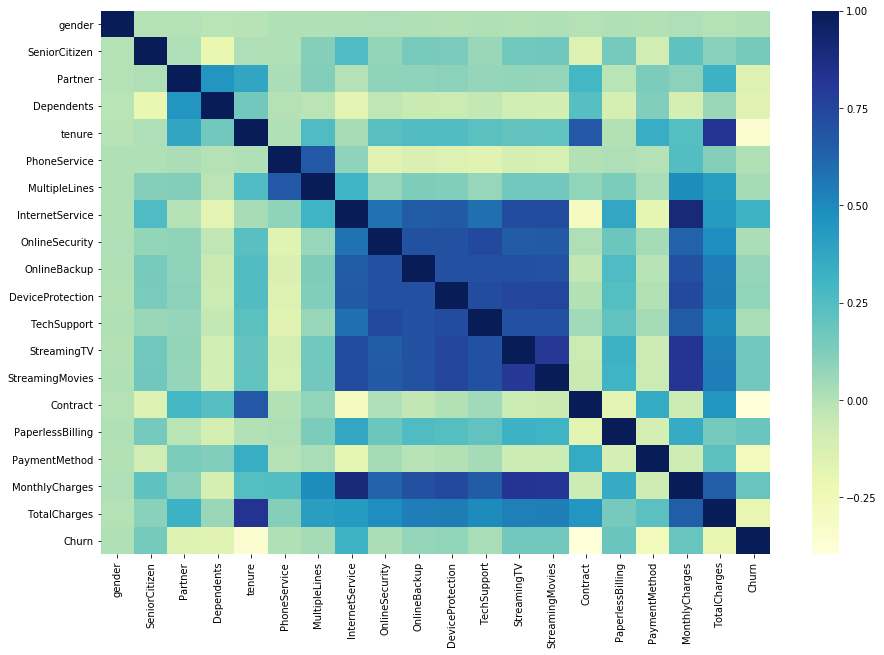

In [209]:
fig = plt.figure(figsize=(15,10))
corr = tele_data.corr(method = 'pearson')
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [210]:
corr_stack = corr.abs().unstack()
ordered_stack = corr_stack.sort_index(ascending=False)
order_corr = []

for num in range(len(ordered_stack)):
    if ordered_stack[num] > 0.7 and ordered_stack[num] < 1.0:
        order_corr.append(num)
        
print(ordered_stack[order_corr])

tenure            TotalCharges        0.825880
TotalCharges      tenure              0.825880
TechSupport       StreamingTV         0.703306
                  StreamingMovies     0.704595
                  OnlineSecurity      0.734696
                  OnlineBackup        0.708659
                  DeviceProtection    0.724817
StreamingTV       TechSupport         0.703306
                  StreamingMovies     0.807118
                  OnlineBackup        0.702605
                  MonthlyCharges      0.820193
                  InternetService     0.725522
                  DeviceProtection    0.747489
StreamingMovies   TechSupport         0.704595
                  StreamingTV         0.807118
                  MonthlyCharges      0.817525
                  InternetService     0.722592
                  DeviceProtection    0.752755
OnlineSecurity    TechSupport         0.734696
                  OnlineBackup        0.704598
                  DeviceProtection    0.701112
OnlineBackup 

In [211]:
ordered_stack[order_corr]

tenure            TotalCharges        0.825880
TotalCharges      tenure              0.825880
TechSupport       StreamingTV         0.703306
                  StreamingMovies     0.704595
                  OnlineSecurity      0.734696
                  OnlineBackup        0.708659
                  DeviceProtection    0.724817
StreamingTV       TechSupport         0.703306
                  StreamingMovies     0.807118
                  OnlineBackup        0.702605
                  MonthlyCharges      0.820193
                  InternetService     0.725522
                  DeviceProtection    0.747489
StreamingMovies   TechSupport         0.704595
                  StreamingTV         0.807118
                  MonthlyCharges      0.817525
                  InternetService     0.722592
                  DeviceProtection    0.752755
OnlineSecurity    TechSupport         0.734696
                  OnlineBackup        0.704598
                  DeviceProtection    0.701112
OnlineBackup 

In [212]:
corr

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,0.001819,0.001379,-0.010349,-0.005285,0.007515,0.010284,0.009643,0.013233,0.011081,0.003168,0.008215,0.007163,0.009072,-0.000095,0.011902,0.004928,0.013779,-0.000048,0.008545
SeniorCitizen,0.001819,1.000000,0.016957,-0.210550,0.015683,0.008392,0.113769,0.259030,0.081766,0.144762,0.140226,0.067318,0.167123,0.176125,-0.141820,0.156258,-0.093712,0.219874,0.102411,0.150541
Partner,0.001379,0.016957,1.000000,0.452269,0.381912,0.018397,0.118037,0.000938,0.092034,0.091536,0.099077,0.077252,0.080205,0.076076,0.294094,-0.013957,0.133280,0.097825,0.319072,-0.149982
Dependents,-0.010349,-0.210550,0.452269,1.000000,0.163386,-0.001078,-0.019178,-0.177789,-0.028964,-0.061970,-0.068296,-0.040057,-0.085909,-0.099795,0.240556,-0.110131,0.124002,-0.112343,0.064653,-0.163128
tenure,-0.005285,0.015683,0.381912,0.163386,1.000000,0.007877,0.259112,0.031272,0.232295,0.253575,0.253834,0.230429,0.200646,0.203834,0.676734,0.004823,0.340939,0.246862,0.825880,-0.354049
PhoneService,0.007515,0.008392,0.018397,-0.001078,0.007877,1.000000,0.674824,0.094182,-0.158997,-0.129432,-0.141055,-0.160950,-0.107242,-0.114798,0.003019,0.016696,-0.003106,0.248033,0.113008,0.011691
MultipleLines,0.010284,0.113769,0.118037,-0.019178,0.259112,0.674824,1.000000,0.308546,0.069959,0.130978,0.125447,0.069706,0.166256,0.163218,0.084037,0.133538,0.026248,0.491412,0.412495,0.036148
InternetService,0.009643,0.259030,0.000938,-0.177789,0.031272,0.094182,0.308546,1.000000,0.581993,0.658487,0.662791,0.585745,0.725522,0.722592,-0.288855,0.377644,-0.178655,0.905389,0.428212,0.316350
OnlineSecurity,0.013233,0.081766,0.092034,-0.028964,0.232295,-0.158997,0.069959,0.581993,1.000000,0.704598,0.701112,0.734696,0.661541,0.666682,0.016495,0.184449,0.035563,0.635260,0.483157,0.023014
OnlineBackup,0.011081,0.144762,0.091536,-0.061970,0.253575,-0.129432,0.130978,0.658487,0.704598,1.000000,0.710790,0.708659,0.702605,0.699828,-0.034745,0.260691,-0.003786,0.710175,0.537726,0.073934


- 상관분석 결과, 가입 개월수와 지급 금액 수는 높은 상관관계를 보여주고 있음(0.82)
- 인터넷 가입자의 경우, 온라인 보안, 백업 서비스, 장비 보험, 기술 지원, TV 스트리밍, 영화 스트리밍 서비스 등의 가입 여부와 높은 상관관계를 보임
- 하지만, 가입 여부와 가입 수준 등 범주형 변수이므로, pearson 상관계수를 확인하는 것이 적절한 것인지 의문
- 그래서 spearman의 상관계수 방식을 통해 독립성을 검증해보자

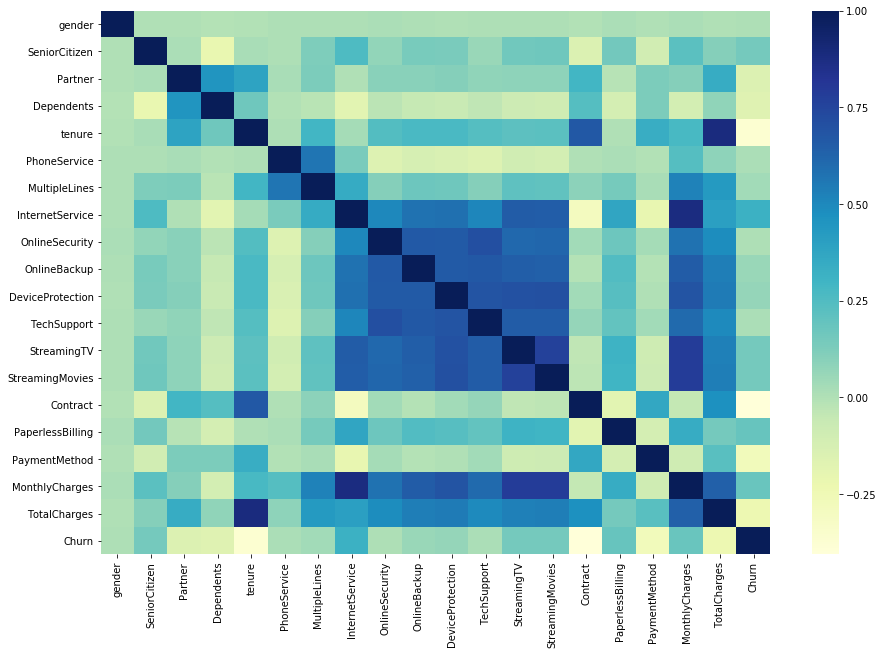

In [213]:
fig = plt.figure(figsize=(15,10))
corr_sprm = tele_data.corr(method = 'spearman')
sns.heatmap(corr_sprm, cmap="YlGnBu")
plt.show()

In [16]:
corr_sprm

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,0.001819,0.001379,-0.010349,-0.003718,0.007515,0.010082,0.010150,0.013542,0.011472,0.002948,0.008314,0.007280,0.009390,-0.001037,0.011902,0.004651,0.013085,0.001177,0.008545
SeniorCitizen,0.001819,1.000000,0.016957,-0.210550,0.017408,0.008392,0.125338,0.263197,0.075307,0.137975,0.133141,0.059887,0.160605,0.170399,-0.143143,0.156258,-0.103386,0.220737,0.107248,0.150541
Partner,0.001379,0.016957,1.000000,0.452269,0.387972,0.018397,0.128250,0.001018,0.095975,0.098607,0.106674,0.080719,0.088308,0.083946,0.295210,-0.013957,0.130683,0.109456,0.343196,-0.149982
Dependents,-0.010349,-0.210550,0.452269,1.000000,0.169018,-0.001078,-0.021191,-0.178395,-0.022647,-0.053118,-0.059998,-0.033928,-0.076826,-0.091947,0.241624,-0.110131,0.128859,-0.105449,0.082890,-0.163128
tenure,-0.003718,0.017408,0.387972,0.169018,1.000000,0.007734,0.292442,0.031182,0.242226,0.270167,0.272358,0.241211,0.220248,0.223981,0.673986,0.005955,0.337963,0.275339,0.889177,-0.369659
PhoneService,0.007515,0.008392,0.018397,-0.001078,0.007734,1.000000,0.567931,0.136641,-0.156444,-0.122512,-0.135082,-0.158355,-0.096024,-0.104107,0.002543,0.016696,-0.003083,0.240266,0.084910,0.011691
MultipleLines,0.010082,0.125338,0.128250,-0.021191,0.292442,0.567931,1.000000,0.350194,0.105219,0.170904,0.166565,0.105191,0.210075,0.208002,0.089813,0.145852,0.019937,0.526447,0.430896,0.038156
InternetService,0.010150,0.263197,0.001018,-0.178395,0.031182,0.136641,0.350194,1.000000,0.505543,0.582418,0.587933,0.509000,0.656583,0.652090,-0.286951,0.374351,-0.204973,0.884535,0.403318,0.320636
OnlineSecurity,0.013542,0.075307,0.095975,-0.022647,0.242226,-0.156444,0.105219,0.505543,1.000000,0.667961,0.664227,0.710808,0.611327,0.616422,0.035108,0.174859,0.031355,0.577432,0.487169,0.011566
OnlineBackup,0.011472,0.137975,0.098607,-0.053118,0.270167,-0.122512,0.170904,0.582418,0.667961,1.000000,0.664379,0.671877,0.647114,0.643049,-0.008393,0.249267,-0.007736,0.659291,0.534767,0.057207


In [214]:
corr_stack = corr_sprm.abs().unstack()
ordered_stack = corr_stack.sort_index(ascending=False)
order_corr = []

for num in range(len(ordered_stack)):
    if ordered_stack[num] > 0.7 and ordered_stack[num] < 1.0:
        order_corr.append(num)
        
print(ordered_stack[order_corr])

tenure            TotalCharges        0.889177
TotalCharges      tenure              0.889177
TechSupport       OnlineSecurity      0.710808
StreamingTV       StreamingMovies     0.765461
                  MonthlyCharges      0.789943
                  DeviceProtection    0.700557
StreamingMovies   StreamingTV         0.765461
                  MonthlyCharges      0.786510
                  DeviceProtection    0.706175
OnlineSecurity    TechSupport         0.710808
MonthlyCharges    StreamingTV         0.789943
                  StreamingMovies     0.786510
                  InternetService     0.884535
InternetService   MonthlyCharges      0.884535
DeviceProtection  StreamingTV         0.700557
                  StreamingMovies     0.706175
dtype: float64


- 분석 결과, 피어슨 상관계수와 유사한 결과가 나왓으나, 스피어만 상관계수에서는 특성 간 상관계수 수준이 조금 낮아짐
- 그 중에서도 0.8 이상의 상관계수를 기록하는 특성-관계를 고름
- tenure, StreamingMovies를 삭제하기로 함

In [215]:
#다중공선성 문제를 일으킬 가능성이 있는 특성 삭제
tele_data = tele_data.drop('tenure', 1)

In [216]:
tele_data = tele_data.drop('StreamingMovies', 1)

In [158]:
tele_data = tele_data.drop('MonthlyCharges', 1)

In [159]:
tele_data = tele_data.drop('StreamingTV', 1)

In [186]:
tele_data = tele_data.drop('InternetService', 1)

In [217]:
tele_data.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

### SVM 분석

In [218]:
from sklearn import datasets, svm, metrics
import datetime as dt

In [219]:
X_data = tele_data.iloc[:,:-1]

In [220]:
y = tele_data.iloc[:,-1]

In [221]:
x_train, x_test = X_data[:2000], X_data[2000:]
y_train, y_test = y[:2000], y[2000:]

In [122]:
svc = svm.SVC(kernel='linear', C=5.0).fit(x_train, y_train)

In [123]:
res = svc.predict(x_test)

In [124]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [125]:
print('정확도 : %.2f' %accuracy_score(y_test,res))

정확도 : 0.79


In [164]:
param_C = 5
param_gamma = 0.05
classifier = svm.SVC(C=param_C, kernel = 'rbf', gamma=param_gamma)

# We learn the digits on train part
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))
classifier.fit(x_train, y_train)
end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2018-06-15 05:26:11.395386
Stop learning 2018-06-15 05:26:11.751408
Elapsed learning 0:00:00.356022


In [165]:
expected = y_test
predicted = classifier.predict(x_test)

In [166]:
print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(expected, predicted)))
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))

Classification report for classifier SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.79      0.85      0.82      3691
          1       0.48      0.38      0.43      1341

avg / total       0.71      0.73      0.72      5032


Confusion matrix:
[[3142  549]
 [ 825  516]]
Accuracy=0.7269475357710652


In [167]:
print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(expected, predicted)))
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))

Classification report for classifier SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.79      0.85      0.82      3691
          1       0.48      0.38      0.43      1341

avg / total       0.71      0.73      0.72      5032


Confusion matrix:
[[3142  549]
 [ 825  516]]
Accuracy=0.7269475357710652


- SVM 분석 결과, 모델의 분류 성능은 76% 수준

### Logistic Regression

In [168]:
from sklearn.linear_model import LogisticRegression
x_data = tele_data.drop('Churn', axis=1)
y_data = tele_data['Churn']

x_train_lr = x_data[2000:]
x_test_lr = x_data[:2000]
y_train_lr = y_data[2000:]
y_test_lr = y_data[:2000]

lr = LogisticRegression()
lr_fit = lr.fit(x_train_lr, y_train_lr)
cv = StratifiedKFold(n_splits=2)
lr_cv = cross_val_score(lr, x_test_lr, y_test_lr, cv = cv)
score = round(Decimal(np.mean(lr_cv)*100), 2)
print('Accuracy: {}%'.format(score))
lr_fit

Accuracy: 79.40%


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [169]:
predictions = lr.predict(x_test_lr)

In [170]:
score = lr.score(x_test_lr, y_test_lr)
print(score)

0.8055


In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [172]:
cm = metrics.confusion_matrix(y_test_lr, predictions)
print(cm)

[[1333  139]
 [ 250  278]]


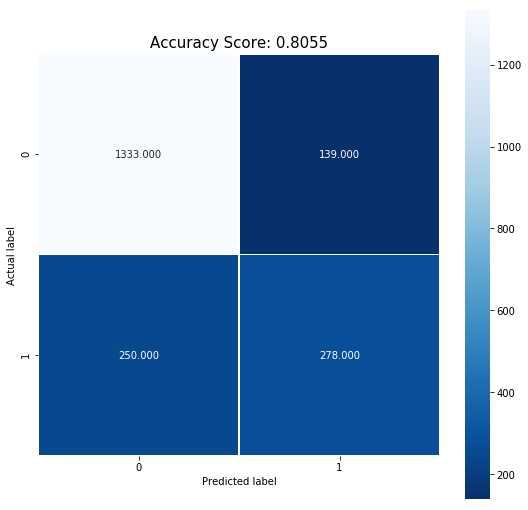

In [173]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [174]:
from sklearn import linear_model

In [175]:
logreg = linear_model.LogisticRegression(C=1e5) # 정규화
logreg.fit(x_data, y_data)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

- 로지스틱 모형 분석 결과, 모델의 분류 성능은 81% 수준

In [231]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

fpr1, tpr1, thresholds1 = roc_curve(y_data, classifier.decision_function(x_data))
fpr2, tpr2, thresholds1 = roc_curve(y_data, lr_fit.decision_function(x_data))

AttributeError: 'MLPClassifier' object has no attribute 'decision_function'

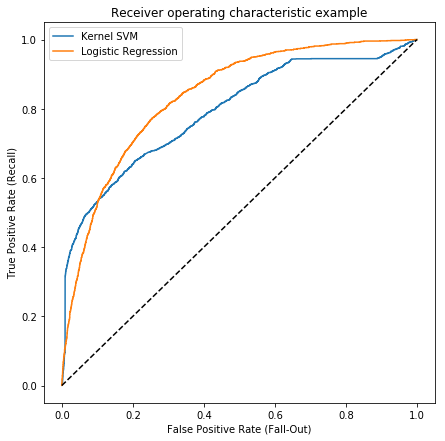

In [235]:
plt.figure(figsize=(7,7))
plt.plot(fpr1, tpr1, label="Kernel SVM")
plt.plot(fpr2, tpr2, label="Logistic Regression")
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

### Neural Network

In [228]:
from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier
import time

In [229]:
start_time = time.time()
mlp = MLPClassifier(hidden_layer_sizes=(3,2),
                    max_iter=50, solver='sgd', verbose=1, learning_rate_init=.0015)
mlp.fit(x_train, y_train)

print("Training set score: %f" % mlp.score(x_train, y_train))
print("Test set score: %f" % mlp.score(x_test, y_test))
print("--- %s seconds ---" % (time.time() - start_time))

Iteration 1, loss = 2.64546141
Iteration 2, loss = 0.76022945
Iteration 3, loss = 0.75522566
Iteration 4, loss = 0.62422739
Iteration 5, loss = 0.57797883
Iteration 6, loss = 0.58281162
Iteration 7, loss = 0.57900202
Iteration 8, loss = 0.57756539
Iteration 9, loss = 0.57768763
Iteration 10, loss = 0.57737258
Iteration 11, loss = 0.57768857
Iteration 12, loss = 0.57731664
Iteration 13, loss = 0.57742657
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Training set score: 0.736000
Test set score: 0.733506
--- 0.051834821701049805 seconds ---


In [192]:
import scipy.stats

In [193]:
import statsmodels.api as sm

In [194]:
x_data_logit = np.asarray(x_data)

In [195]:
logit = sm.Logit(y_data, x_data_logit)

In [196]:
result = logit.fit() 

Optimization terminated successfully.
         Current function value: 0.428366
         Iterations 7


In [197]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7017
Method:                           MLE   Df Model:                           14
Date:                Fri, 15 Jun 2018   Pseudo R-squ.:                  0.2602
Time:                        05:31:31   Log-Likelihood:                -3012.3
converged:                       True   LL-Null:                       -4071.7
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0337      0.063     -0.537      0.591      -0.157       0.089
x2             0.1498      0.084      1.791      0.073      -0.014       0.314
x3            -0.1096      0.076     -1.450      0.147      -0.258       0.039
x4            -0.2072      0.088     -2.354      0.019      -0.380      -0.035
x5            -1.1922      0.127     -9.372      0.000      -1.441      -0.943
x6             0.3161      0.078      4.059      0.000       0.163       0.469
x7             1.2526      0.074     16.963      0.000       1.108       1.397
x8            -0.3878      0.075     -5.156      0.000      -0.535      -0.240
x9            -0.1534      0.071     -2.160      0.031      -0.293      -0.014
x10            0.0889      0.073      1.225      0.221      -0.053       0.231
x11           -0.2425      0.077     -3.142      0.002      -0.394      -0.091
x12           -0.8921      0.071    -12.509      0.000      -1.032      -0.752
x13            0.2900      0.071      4.102      0.000       0.151       0.429
x14           -0.2435      0.027     -8.891      0.000      -0.297      -0.190
x15           -0.0002   2.37e-05    -10.148      0.000      -0.000      -0.000
==============================================================================
"""

In [198]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit_mod = sm.Logit(y_data, x_data)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7017
Method:                           MLE   Df Model:                           14
Date:                Fri, 15 Jun 2018   Pseudo R-squ.:                  0.2602
Time:                        05:31:33   Log-Likelihood:                -3012.3
converged:                       True   LL-Null:                       -4071.7
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
gender              -0.0337      0.063     -0.537      0.591      -0.157       0.089
SeniorCitizen        0.1498      0.084      1.791      0.073      -0.014       0.314
Partner             -0.1096 

In [184]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit_mod = sm.Logit(y_data, x_data)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7017
Method:                           MLE   Df Model:                           14
Date:                Fri, 15 Jun 2018   Pseudo R-squ.:                  0.2602
Time:                        05:26:38   Log-Likelihood:                -3012.3
converged:                       True   LL-Null:                       -4071.7
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
gender              -0.0337      0.063     -0.537      0.591      -0.157       0.089
SeniorCitizen        0.1498      0.084      1.791      0.073      -0.014       0.314
Partner             -0.1096 

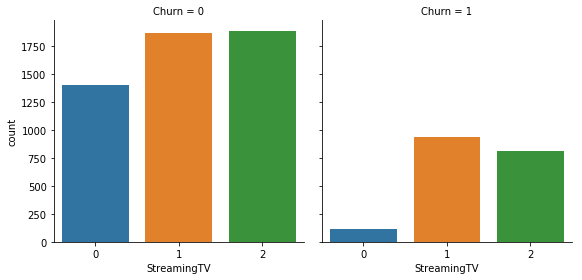

In [91]:
sns.factorplot(x='StreamingTV', col='Churn', kind='count', data=tele_data);

- TV 서비스에 가입하지 않은 경우에 이탈 빈도가 높지만, 가입한 경우의 빈도와 큰 차이를 보이고 있지 않음.

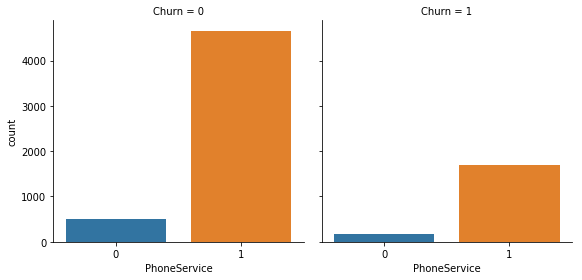

In [217]:
sns.factorplot(x='PhoneService', col='Churn', kind='count', data=tele_data);

- 전화 서비스에 가입한 사람일수록 이탈 빈도가 낮음

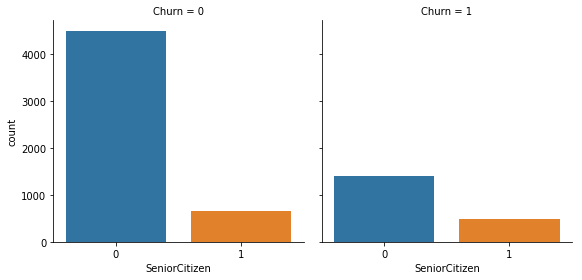

In [90]:
sns.factorplot(x='SeniorCitizen', col='Churn', kind='count', data=tele_data);

- 고령 사용자 층에서는 이탈 여부에 대한 큰 차이가 없음.

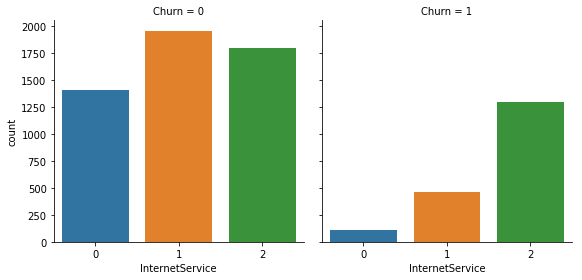

In [83]:
sns.factorplot(x='InternetService', col='Churn', kind='count', data=tele_data);

- 인터넷 연결 방식 중 광섬유 방식(Fiber Optic)에 문제가 있는 것으로 추정됨.

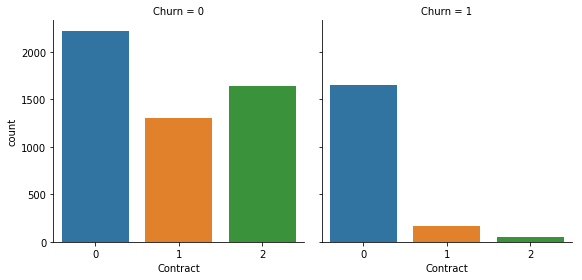

In [84]:
sns.factorplot(x='Contract', col='Churn', kind='count', data=tele_data);

- 장기 가입자일수록 이탈하지 않고, 단기간 가입자일수록 이탈 빈도가 높음

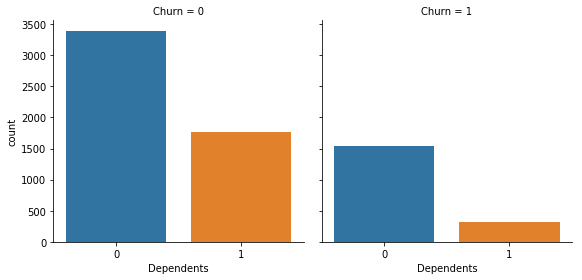

In [85]:
sns.factorplot(x='Dependents', col='Churn', kind='count', data=tele_data);

- 부양할 가족이 있는 경우가 고객이 이탈하지 않는 빈도가 높음

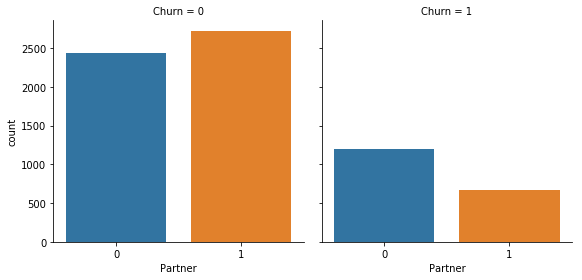

In [86]:
sns.factorplot(x='Partner', col='Churn', kind='count', data=tele_data);

- 배우자가 있는 경우가 고객이 이탈하지 않는 빈도가 높음